In [1]:
# Cell 001
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement des données
df = pd.read_csv('data/clean.csv')

In [2]:
# Cell 002
# Nous avons notre dataset principal. Créons maintenant 3 autres datasets plus petits.
# Pour cela, nous allons nous servir de la colonne 'days_since_last_order'.
# Tout d'abord, trier le dataset par 'days_since_last_order'.

df = df.sort_values(by='days_since_last_order')

In [3]:
# Cell 003
# Créons maintenant 3 datasets dégradés.
# Le premier dataset correspond aux données de df -15% du nombre de lignes, selon l'ordre défini.
# Le deuxième dataset correspond aux données de df -30% du nombre de lignes, selon l'ordre défini.
# Le troisième dataset correspond aux données de df -50% du nombre de lignes, selon l'ordre défini.

# Calcul du nombre de lignes pour chaque dataset dégradé
n_rows = len(df)
n_rows_85 = int(n_rows * 0.85)  # -15%
n_rows_70 = int(n_rows * 0.70)  # -30%
n_rows_50 = int(n_rows * 0.50)  # -50%

# Création des datasets dégradés
df_85 = df.head(n_rows_85)
df_70 = df.head(n_rows_70)
df_50 = df.head(n_rows_50)

# Affichage des tailles des datasets pour vérification
print(f"Taille du dataset original : {len(df)}")
print(f"Taille du dataset -15% : {len(df_85)}")
print(f"Taille du dataset -30% : {len(df_70)}")
print(f"Taille du dataset -50% : {len(df_50)}")

Taille du dataset original : 94269
Taille du dataset -15% : 80128
Taille du dataset -30% : 65988
Taille du dataset -50% : 47134


In [4]:
# Cell 004
# Calcul des décalages en jours depuis df50
max_days_50 = df_50['days_since_last_order'].max()
max_days_70 = df_70['days_since_last_order'].max()
max_days_85 = df_85['days_since_last_order'].max()
max_days_original = df['days_since_last_order'].max()

# Calcul des décalages
df_50_decalage_days = 0  # Point de départ
df_70_decalage_days = int(max_days_70 - max_days_50)
df_85_decalage_days = int(max_days_85 - max_days_50)
df_decalage_days = int(max_days_original - max_days_50)

# Affichage des résultats
print(f"Décalage pour df_50 : {df_50_decalage_days} jours")
print(f"Décalage pour df_70 : {df_70_decalage_days} jours")
print(f"Décalage pour df_85 : {df_85_decalage_days} jours")
print(f"Décalage pour df : {df_decalage_days} jours")

Décalage pour df_50 : 0 jours
Décalage pour df_70 : 94 jours
Décalage pour df_85 : 201 jours
Décalage pour df : 475 jours


In [5]:
# Cell 005
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

df['total_orders_normalized'] = scaler.fit_transform(df[['total_orders']])
df['avg_delivery_time_days_normalized'] = scaler.fit_transform(df[['avg_delivery_time_days']])
df['days_since_last_order_normalized'] = scaler.fit_transform(df[['days_since_last_order']])
df['total_spent_normalized'] = scaler.fit_transform(df[['total_spent']])
df['avg_review_score_normalized'] = scaler.fit_transform(df[['avg_review_score']])
df['max_delivery_delay_days_normalized'] = scaler.fit_transform(df[['max_delivery_delay_days']])
df['has_comment_normalized'] = scaler.fit_transform(df[['has_comment']])
df['last_payment_installments_normalized'] = scaler.fit_transform(df[['last_payment_installments']])
df['avg_review_score_normalized'] = scaler.fit_transform(df[['avg_review_score']])

df_85['total_orders_normalized'] = scaler.fit_transform(df_85[['total_orders']])
df_85['avg_delivery_time_days_normalized'] = scaler.fit_transform(df_85[['avg_delivery_time_days']])
df_85['days_since_last_order_normalized'] = scaler.fit_transform(df_85[['days_since_last_order']])
df_85['total_spent_normalized'] = scaler.fit_transform(df_85[['total_spent']])
df_85['avg_review_score_normalized'] = scaler.fit_transform(df_85[['avg_review_score']])
df_85['max_delivery_delay_days_normalized'] = scaler.fit_transform(df_85[['max_delivery_delay_days']])
df_85['has_comment_normalized'] = scaler.fit_transform(df_85[['has_comment']])
df_85['last_payment_installments_normalized'] = scaler.fit_transform(df_85[['last_payment_installments']])
df_85['avg_review_score_normalized'] = scaler.fit_transform(df_85[['avg_review_score']])

df_70['total_orders_normalized'] = scaler.fit_transform(df_70[['total_orders']])
df_70['avg_delivery_time_days_normalized'] = scaler.fit_transform(df_70[['avg_delivery_time_days']])
df_70['days_since_last_order_normalized'] = scaler.fit_transform(df_70[['days_since_last_order']])
df_70['total_spent_normalized'] = scaler.fit_transform(df_70[['total_spent']])
df_70['avg_review_score_normalized'] = scaler.fit_transform(df_70[['avg_review_score']])
df_70['max_delivery_delay_days_normalized'] = scaler.fit_transform(df_70[['max_delivery_delay_days']])
df_70['has_comment_normalized'] = scaler.fit_transform(df_70[['has_comment']])
df_70['last_payment_installments_normalized'] = scaler.fit_transform(df_70[['last_payment_installments']])
df_70['avg_review_score_normalized'] = scaler.fit_transform(df_70[['avg_review_score']])

df_50['total_orders_normalized'] = scaler.fit_transform(df_50[['total_orders']])
df_50['avg_delivery_time_days_normalized'] = scaler.fit_transform(df_50[['avg_delivery_time_days']])
df_50['days_since_last_order_normalized'] = scaler.fit_transform(df_50[['days_since_last_order']])
df_50['total_spent_normalized'] = scaler.fit_transform(df_50[['total_spent']])
df_50['avg_review_score_normalized'] = scaler.fit_transform(df_50[['avg_review_score']])
df_50['max_delivery_delay_days_normalized'] = scaler.fit_transform(df_50[['max_delivery_delay_days']])
df_50['has_comment_normalized'] = scaler.fit_transform(df_50[['has_comment']])
df_50['last_payment_installments_normalized'] = scaler.fit_transform(df_50[['last_payment_installments']])
df_50['avg_review_score_normalized'] = scaler.fit_transform(df_50[['avg_review_score']])

C:\Users\vdn\AppData\Local\Temp\ipykernel_33924\3304028081.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_85['total_orders_normalized'] = scaler.fit_transform(df_85[['total_orders']])
C:\Users\vdn\AppData\Local\Temp\ipykernel_33924\3304028081.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_85['avg_delivery_time_days_normalized'] = scaler.fit_transform(df_85[['avg_delivery_time_days']])
C:\Users\vdn\AppData\Local\Temp\ipykernel_33924\3304028081.py:17: SettingWithCopyWarning: 
A value is tryi

In [6]:
# Cell 006
features = [
    'total_orders_normalized', 
    'avg_delivery_time_days_normalized', 
    'days_since_last_order_normalized', 
    'total_spent_normalized', 
    'avg_review_score_normalized', 
    'max_delivery_delay_days_normalized', 
    'has_comment_normalized', 
    'last_payment_installments_normalized'
]

In [7]:
# Cell 007
# Préparation des données pour le clustering
def prepare_data(df):
    X = df[features]
    scaler = StandardScaler()
    return scaler.fit_transform(X)

# Préparation des données pour df_50
X_50_scaled = prepare_data(df_50)

# Création et entraînement du modèle KMeans sur df_50
kmeans_model = KMeans(n_clusters=6, random_state=42)
kmeans_model.fit(X_50_scaled)

print("Modèle KMeans entraîné sur df_50.")

Modèle KMeans entraîné sur df_50.


In [8]:
# Cell 008
# Application du modèle KMeans à tous les dataframes
df['cluster'] = kmeans_model.predict(prepare_data(df))
df_85['cluster'] = kmeans_model.predict(prepare_data(df_85))
df_70['cluster'] = kmeans_model.predict(prepare_data(df_70))
df_50['cluster'] = kmeans_model.predict(X_50_scaled)  # Utiliser les données déjà préparées pour df_50

# Calcul des scores ARI
ari_50 = 1.0  # Le score ARI de df_50 par rapport à lui-même est toujours 1
ari_70 = adjusted_rand_score(df_50['cluster'], df_70['cluster'].iloc[:len(df_50)])
ari_85 = adjusted_rand_score(df_50['cluster'], df_85['cluster'].iloc[:len(df_50)])
ari_100 = adjusted_rand_score(df_50['cluster'], df['cluster'].iloc[:len(df_50)])

# Création de la matrice de décalage
decalage_matrix = pd.DataFrame({
    'Dataset': ['df_50', 'df_70', 'df_85', 'df'],
    'Décalage (jours)': [df_50_decalage_days, df_70_decalage_days, df_85_decalage_days, df_decalage_days],
    'ARI Score': [ari_50, ari_70, ari_85, ari_100]
})

print("Matrice de décalage et scores ARI:")
print(decalage_matrix)

C:\Users\vdn\AppData\Local\Temp\ipykernel_33924\4114265268.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_85['cluster'] = kmeans_model.predict(prepare_data(df_85))
C:\Users\vdn\AppData\Local\Temp\ipykernel_33924\4114265268.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_70['cluster'] = kmeans_model.predict(prepare_data(df_70))
C:\Users\vdn\AppData\Local\Temp\ipykernel_33924\4114265268.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

Matrice de décalage et scores ARI:
  Dataset  Décalage (jours)  ARI Score
0   df_50                 0   1.000000
1   df_70                94   0.736857
2   df_85               201   0.665414
3      df               475   0.643333


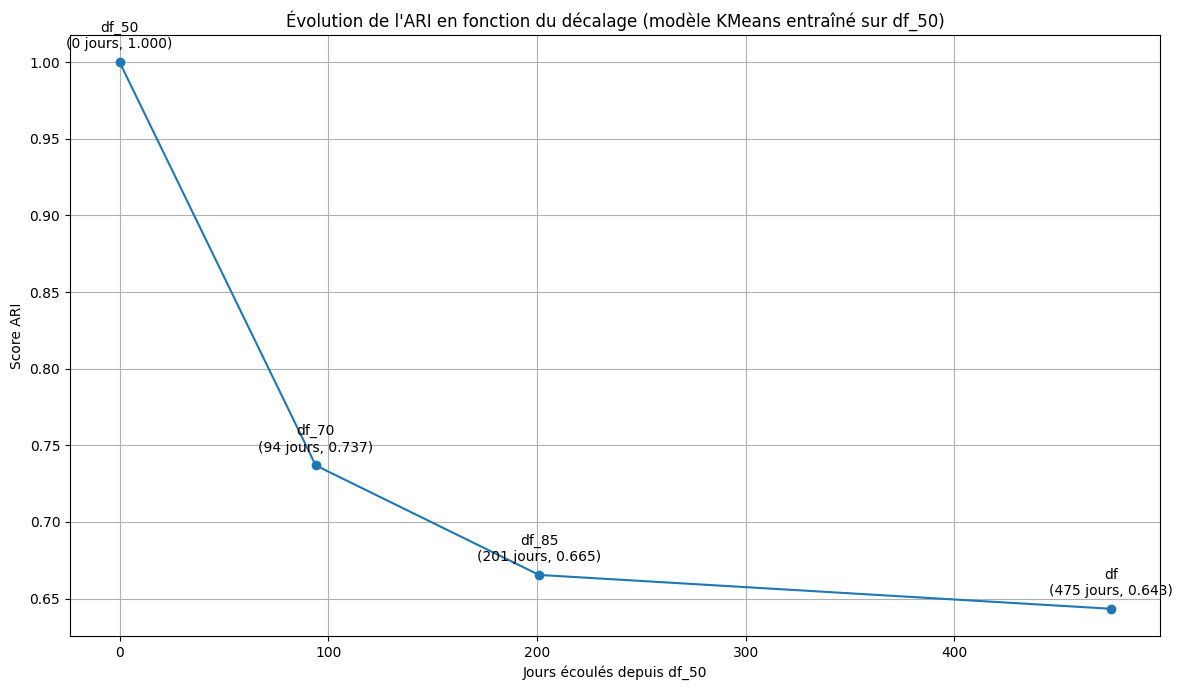

In [9]:
# Cell 009
# Création de la courbe d'évolution de l'ARI
plt.figure(figsize=(12, 7))
plt.plot(decalage_matrix['Décalage (jours)'], decalage_matrix['ARI Score'], marker='o')
plt.title("Évolution de l'ARI en fonction du décalage (modèle KMeans entraîné sur df_50)")
plt.xlabel("Jours écoulés depuis df_50")
plt.ylabel("Score ARI")
plt.grid(True)

# Ajout des annotations pour chaque point
for i, row in decalage_matrix.iterrows():
    plt.annotate(f"{row['Dataset']}\n({row['Décalage (jours)']} jours, {row['ARI Score']:.3f})",
                 (row['Décalage (jours)'], row['ARI Score']),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center')

plt.tight_layout()
plt.show()